In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import os.path

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

from scipy.cluster.vq import kmeans, vq

In [2]:
file_name = 'combine.csv'
combine = pd.DataFrame()

if os.path.isfile(file_name):
    combine = pd.read_csv(file_name)
else:
    for i in range(2000, 2024):
        url = f'https://www.pro-football-reference.com/draft/{i}-combine.htm'
        web_data = pd.read_html(url)[0]
        web_data['Season'] = i
        web_data = web_data.query('Ht != "Ht"')
        combine = pd.concat([combine, web_data])
    combine.reset_index(drop=True, inplace=True)
    combine.to_csv(file_name, index=False)


In [3]:
combine[['Ht_ft', 'Ht_in']] = combine['Ht'].str.split('-', expand=True)
combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               7999 non-null   object 
 1   Pos                  7999 non-null   object 
 2   School               7999 non-null   object 
 3   College              6525 non-null   object 
 4   Ht                   7970 non-null   object 
 5   Wt                   7975 non-null   float64
 6   40yd                 7416 non-null   float64
 7   Vertical             6162 non-null   float64
 8   Bench                5197 non-null   float64
 9   Broad Jump           6086 non-null   float64
 10  3Cone                4873 non-null   float64
 11  Shuttle              4993 non-null   float64
 12  Drafted (tm/rnd/yr)  5126 non-null   object 
 13  Season               7999 non-null   int64  
 14  Ht_ft                7970 non-null   object 
 15  Ht_in                7970 non-null   o

In [4]:
combine = combine.astype({
    'Wt': float,
    '40yd': float,
    'Vertical': float,
    'Bench': float,
    'Broad Jump': float,
    '3Cone': float,
    'Shuttle': float,
    'Ht_ft': float,
    'Ht_in': float
})
combine.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr),Season,Ht_ft,Ht_in
0,John Abraham,OLB,South Carolina,NaN,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,New York Jets / 1st / 13th pick / 2000,2000,6.0,4.0
1,Shaun Alexander,RB,Alabama,College Stats,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Seattle Seahawks / 1st / 19th pick / 2000,2000,6.0,0.0
2,Darnell Alford,OT,Boston Col.,NaN,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98,Kansas City Chiefs / 6th / 188th pick / 2000,2000,6.0,4.0
3,Kyle Allamon,TE,Texas Tech,NaN,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49,NaN,2000,6.0,2.0
4,Rashard Anderson,CB,Jackson State,NaN,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,Carolina Panthers / 1st / 23rd pick / 2000,2000,6.0,2.0


In [5]:
combine['Ht'] = combine['Ht_ft'] * 12 + combine['Ht_in'] # height in inches
combine.drop(columns=['Ht_ft', 'Ht_in'], inplace=True)
combine.describe()

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Season
count,7970.000000,7975.000000,7416.000000,6162.000000,5197.000000,6086.000000,4873.000000,4993.000000,7999.000000
mean,73.801255,242.550094,4.773901,32.929698,20.736194,114.776536,7.284773,4.400925,2011.698087
std,2.646040,45.296794,0.305084,4.213438,6.364858,9.376346,0.417058,0.266781,6.950760
min,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,2000.000000
25%,72.000000,205.000000,4.530000,30.000000,16.000000,109.000000,6.980000,4.200000,2006.000000
50%,74.000000,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,2012.000000
75%,76.000000,279.500000,4.970000,36.000000,25.000000,121.000000,7.530000,4.560000,2018.000000
max,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,2023.000000


<Axes: xlabel='Ht', ylabel='Wt'>

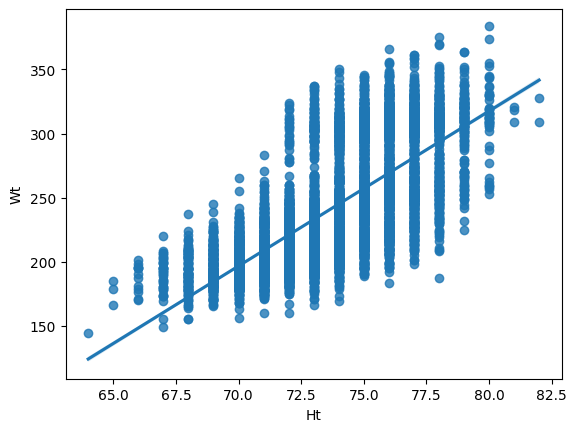

In [6]:
sns.regplot(x='Ht', y='Wt', data=combine)

<Axes: xlabel='Wt', ylabel='40yd'>

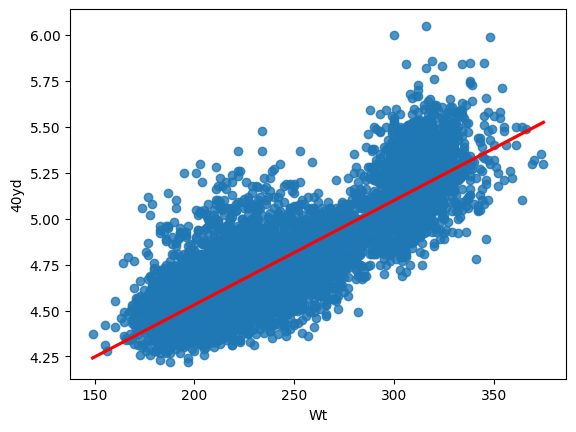

In [7]:
sns.regplot(x='Wt', y='40yd', data=combine, line_kws={'color': 'red'})

<Axes: xlabel='40yd', ylabel='Vertical'>

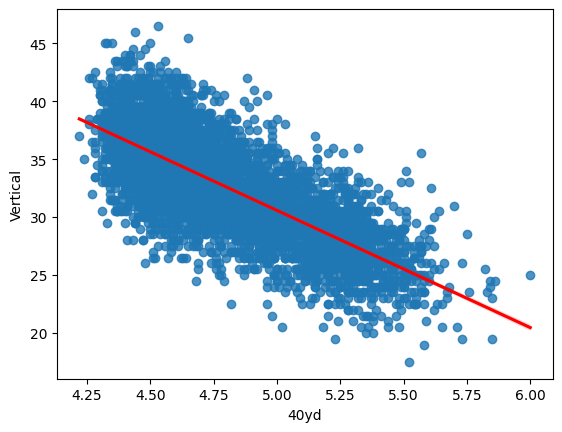

In [8]:
sns.regplot(x='40yd', y='Vertical', data=combine, line_kws={'color': 'red'})

<Axes: xlabel='40yd', ylabel='3Cone'>

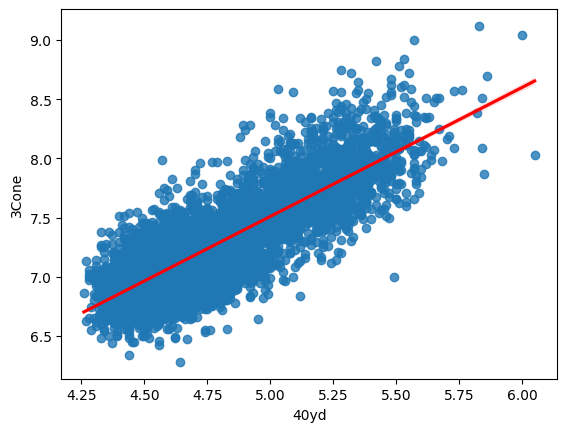

In [9]:
sns.regplot(x='40yd', y='3Cone', data=combine, line_kws={'color': 'red'})

In [10]:
file_name_knn = 'combine_knn.csv'
col_impute = ['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

if os.path.isfile(file_name_knn):
    combine_knn = pd.read_csv(file_name_knn)
else:
    combine_knn = combine.drop(col_impute, axis=1)
    imputer = KNNImputer(n_neighbors=10)
    knn_out = imputer.fit_transform(combine[col_impute])
    knn_out = pd.DataFrame(knn_out)
    knn_out.columns = col_impute
    combine_knn = pd.concat([combine_knn, knn_out], axis=1)
    combine_knn.to_csv(file_name_knn, index=False)

combine_knn.describe()

,Season,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
count,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000,7999.000000
mean,2011.698087,73.801001,242.531054,4.771854,32.968304,20.116413,114.926717,7.239447,4.373734
std,6.950760,2.643153,45.249358,0.300588,3.855688,5.697521,8.766709,0.374693,0.240283
min,2000.000000,64.000000,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000
25%,2006.000000,72.000000,205.000000,4.540000,30.500000,16.000000,109.000000,6.978000,4.210000
50%,2012.000000,74.000000,232.000000,4.690000,33.500000,19.800000,116.500000,7.122000,4.310000
75%,2018.000000,76.000000,279.000000,4.970000,35.500000,24.000000,121.000000,7.450000,4.510000
max,2023.000000,82.000000,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000


In [11]:
pca_wt_ht = PCA(svd_solver='full')
wt_ht = combine[['Wt', 'Ht']] \
    .query('Wt.notnull() and Ht.notnull()') \
    .copy()
pca_fit_wt_ht = pca_wt_ht.fit_transform(wt_ht)
pca_wt_ht.explained_variance_ratio_

array([0.99829949, 0.00170051])

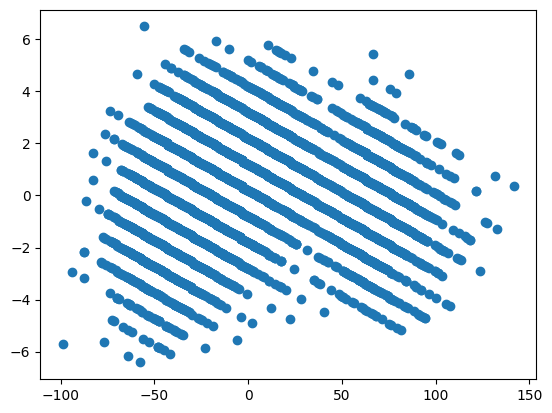

In [12]:
plt.plot(pca_fit_wt_ht[:, 0], pca_fit_wt_ht[:, 1], 'o')

In [13]:
pca_wt_ht.components_

array([[ 0.9991454 ,  0.04133366],
       [-0.04133366,  0.9991454 ]])

In [14]:
scaled_combine_knn = combine_knn[col_impute] - combine_knn[col_impute].mean() / combine_knn[col_impute].std()
pca = PCA(svd_solver='full')
pca_fit = pca.fit_transform(scaled_combine_knn)

In [15]:
rotation = pd.DataFrame(pca.components_, columns=col_impute)
rotation

,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,0.040465,0.983809,0.005588,-0.054202,0.087129,-0.140928,0.006635,0.004146
1,0.060174,0.135196,-0.013052,0.347211,0.143258,0.914636,-0.014430,-0.009228
2,-0.153601,-0.098213,-0.004256,0.016448,0.973876,-0.134268,-0.001260,-0.002987
3,-0.234766,0.022559,-0.004239,0.912744,-0.094308,-0.319787,-0.001028,-0.009879
4,0.956950,-0.060245,0.003656,0.206842,0.120422,-0.151705,-0.016070,-0.006760
5,0.014387,-0.007197,0.211206,0.016260,0.006622,0.014129,0.871298,0.442114
6,-0.007932,-0.002383,0.976547,0.005004,0.003413,0.008512,-0.206249,-0.060337
7,-0.003086,-0.000303,-0.038701,0.007830,0.001151,-0.001446,-0.444733,0.894785


In [16]:
pca.explained_variance_ratio_

array([9.70419421e-01, 1.86809310e-02, 7.49640626e-03, 1.99090334e-03,
       1.37917443e-03, 2.13909370e-05, 7.16236536e-06, 4.61040132e-06])

In [17]:
pca.explained_variance_ratio_.round(4) * 100

array([97.04,  1.87,  0.75,  0.2 ,  0.14,  0.  ,  0.  ,  0.  ])

In [18]:
pca_fit = pd.DataFrame(pca_fit)
pca_fit.columns = [f'PC{i+1}' for i in range(pca_fit.shape[1])]
combine_knn = pd.concat([combine_knn, pca_fit], axis=1)

<Axes: xlabel='PC1', ylabel='PC2'>

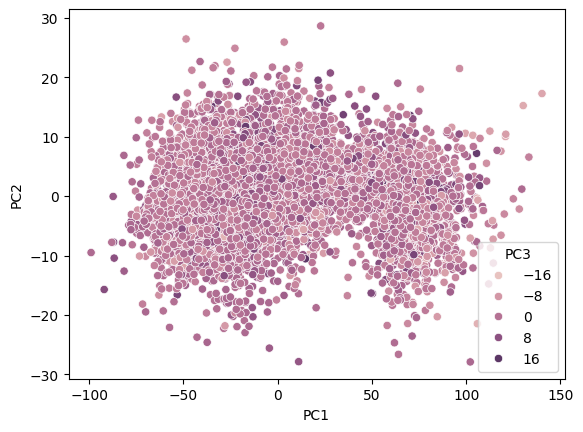

In [19]:
sns.scatterplot(x='PC1', y='PC2', data=combine_knn, hue='PC3')

<Axes: xlabel='PC1', ylabel='PC2'>

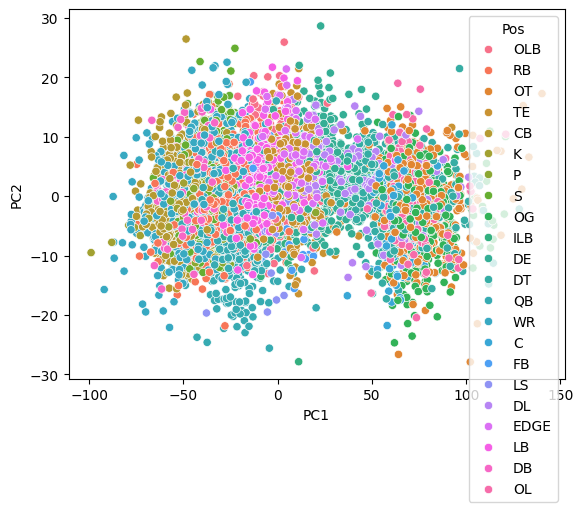

In [20]:
sns.scatterplot(x='PC1', y='PC2', data=combine_knn, hue='Pos')

In [21]:
k_means_fit = kmeans(combine_knn[['PC1', 'PC2']], 5, seed=1234)
combine_knn['Cluster'] = vq(combine_knn[['PC1', 'PC2']], k_means_fit[0])[0]
combine_knn.head()

,Player,Pos,School,College,Drafted (tm/rnd/yr),Season,Ht,Wt,40yd,Vertical,...,Shuttle,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Cluster
0,John Abraham,OLB,South Carolina,NaN,New York Jets / 1st / 13th pick / 2000,2000,76.0,252.0,4.55,33.80,...,4.224,8.958062,4.920082,-0.844866,-0.702975,1.303697,-0.241501,-0.174097,-0.051254,3
1,Shaun Alexander,RB,Alabama,College Stats,Seattle Seahawks / 1st / 19th pick / 2000,2000,72.0,218.0,4.58,34.35,...,4.250,-25.124868,1.724345,0.914775,-0.448256,-0.891142,-0.014837,-0.021329,-0.006808,0
2,Darnell Alford,OT,Boston Col.,NaN,Kansas City Chiefs / 6th / 188th pick / 2000,2000,76.0,334.0,5.56,25.00,...,4.980,93.724406,-9.029095,-3.840987,0.683686,-1.553617,0.482558,0.033679,-0.103043,1
3,Kyle Allamon,TE,Texas Tech,NaN,NaN,2000,74.0,253.0,4.97,29.00,...,4.490,12.062962,-9.951208,0.325844,0.061135,0.393705,-0.154202,0.036610,0.054805,3
4,Rashard Anderson,CB,Jackson State,NaN,Carolina Panthers / 1st / 23rd pick / 2000,2000,74.0,206.0,4.55,34.00,...,4.150,-37.329588,2.489408,0.236045,-2.289199,1.102597,0.183720,-0.039453,-0.160980,0


In [22]:
combine_knn[combine_knn['Cluster'] == 1].groupby('Pos').agg({'Ht': ['count', 'mean'], 'Wt': ['count', 'mean']})

Ht               Wt            
    count       mean count        mean
Pos                                   
C     186  75.311828   186  303.795699
DE     29  76.517241    29  297.344828
DL     56  74.839286    56  310.160714
DT    454  74.967621   454  309.850220
LB      1  77.000000     1  305.000000
OG    417  76.031175   417  314.779376
OL    136  76.363971   136  312.813971
OT    540  77.605556   540  315.516667
TE      1  76.000000     1  336.000000

/var/folders/j7/lmhycdp55cscb8bjsn28cx640000gn/T/ipykernel_61703/3650405593.py:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  combine_knn_cluster.cluster = combine_knn_cluster['Cluster'].astype(str)


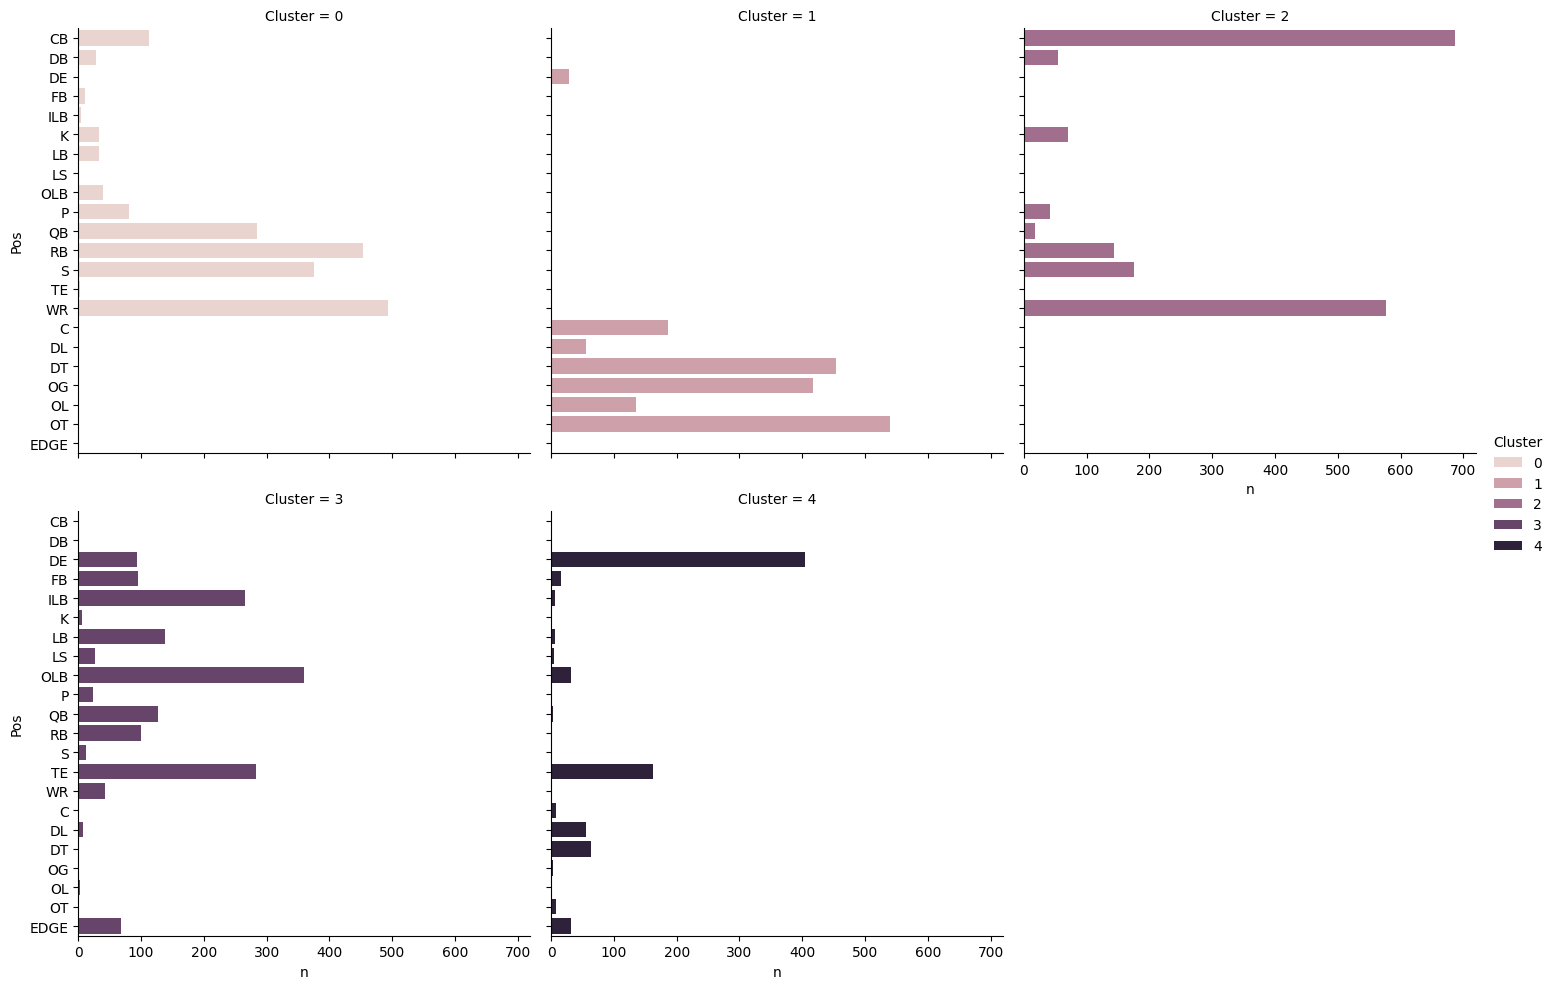

In [23]:
combine_knn_cluster = combine_knn \
    .groupby([
        'Cluster',
        'Pos'
    ]) \
    .agg({
        'Ht': ['count', 'mean'],
        'Wt': ['mean']
    })
combine_knn_cluster.columns = list(map('_'.join, combine_knn_cluster.columns.values))
combine_knn_cluster.reset_index(inplace=True)
combine_knn_cluster.rename(columns={
    'Ht_count': 'n',
    'Ht_mean': 'Ht',
    'Wt_mean': 'Wt'
}, inplace=True)
combine_knn_cluster.cluster = combine_knn_cluster['Cluster'].astype(str)

sns.catplot(x='n', y='Pos', hue='Cluster', data=combine_knn_cluster, kind='bar', col_wrap=3, col='Cluster')